学习处理回归与分类以外的算法。

In [2]:
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# 成本敏感分类

In [3]:
# 定义代价矩阵
costs <- matrix(
  c(-1, 0, 5, 0),
  nrow = 2,
  dimnames = list(
    "Predicted Credit" = c("good", "bad"),
    Truth = c("good", "bad")
  )
)
costs %>% print()

# Truth
# Predicted Credit good bad
#             good   -1   5
#             bad     0   0

                Truth
Predicted Credit good bad
            good   -1   5
            bad     0   0


产生了一个问题，横轴、纵轴交换有影响吗？

## 成本敏感度量

In [ ]:
library(mlr3verse)

tsk_german <- tsk("german_credit")

msr_costs <- msr("classif.costs", costs = costs)
msr_costs

# <MeasureClassifCosts:classif.costs>: Cost-sensitive Classification
# * Packages: mlr3
# * Range: [-Inf, Inf]
# * Minimize: TRUE
# * Average: macro
# * Parameters: normalize=TRUE
# * Properties: -
# * Predict type: response

<MeasureClassifCosts:classif.costs>: Cost-sensitive Classification
* Packages: mlr3
* Range: [-Inf, Inf]
* Minimize: TRUE
* Average: macro
* Parameters: normalize=TRUE
* Properties: -
* Predict type: response

In [ ]:
learners <- c(
  lrn("classif.log_reg"),
  lrn("classif.featureless"),
  lrn("classif.ranger")
)

bmr <- benchmark(benchmark_grid(
  tasks = tsk_german,
  learners = learners,
  resamplings = rsmp("cv", folds = 3)
))

bmr$aggregate(msr_costs)[, c(4, 7)]

# learner_id          classif.costs
# 1 classif.log_reg     0.1500632    
# 2 classif.featureless 0.8001115    
# 3 classif.ranger      0.2570385

INFO  [09:07:14.008] [mlr3] Running benchmark with 9 resampling iterations
INFO  [09:07:14.057] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:07:14.115] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 2/3)
INFO  [09:07:14.158] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 3/3)
INFO  [09:07:14.196] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 1/3)
INFO  [09:07:14.201] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 2/3)
INFO  [09:07:14.206] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 3/3)
INFO  [09:07:14.210] [mlr3] Applying learner 'classif.ranger' on task 'german_credit' (iter 1/3)
INFO  [09:07:17.797] [mlr3] Applying learner 'classif.ranger' on task 'german_credit' (iter 2/3)
INFO  [09:07:17.947] [mlr3] Applying learner 'classif.ranger' on task 'german_credit' (iter 3/3)
INFO  [09:07:18.099] [mlr3] Finish

learner_id,classif.costs
<chr>,<dbl>
classif.log_reg,0.1500632
classif.featureless,0.8001115
classif.ranger,0.2570385


## 阈值处理

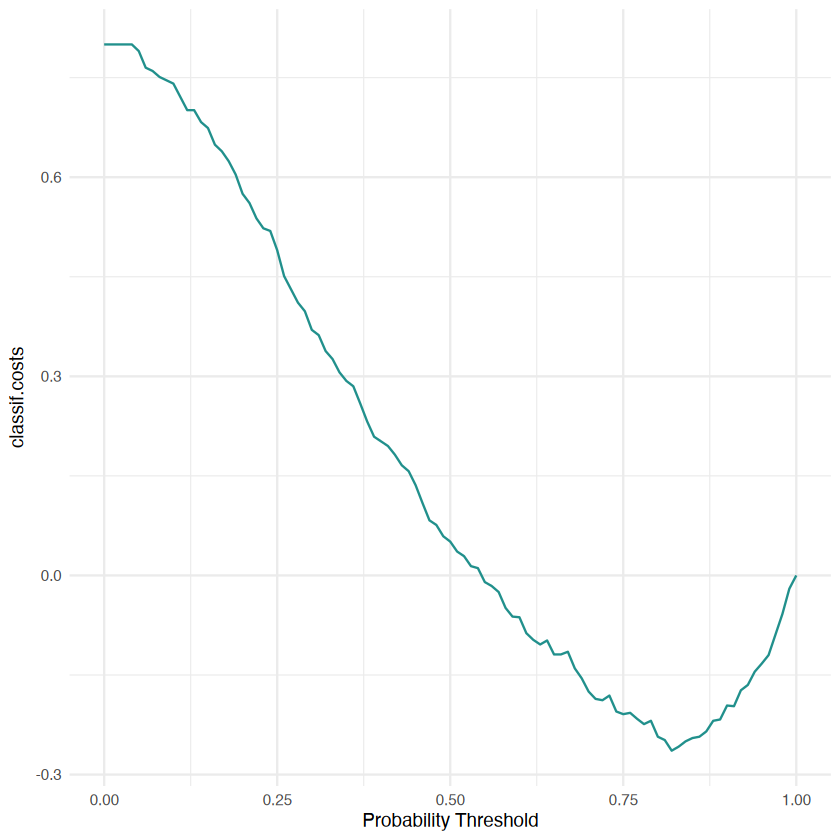

In [9]:
prediction <- lrn("classif.log_reg", predict_type = "prob")$
  train(tsk_german)$
  predict(tsk_german)

autoplot(prediction, type = "threshold", measure = msr_costs)

In [13]:
gr_thresh <- po(
  "learner_cv",
  lrn("classif.log_reg", predict_type = "prob")
) %>>%
  po("tunethreshold", measure = msr_costs)
glrn <- as_learner(gr_thresh)
glrn$id <- "tune_threshold"

lrn_log_reg <- lrn("classif.log_reg", predict_type = "prob")
bmr <- benchmark(benchmark_grid(
  tasks = tsk_german,
  learners = list(lrn_log_reg, glrn),
  resamplings = rsmp("cv", folds = 3)
))

INFO  [09:21:00.650] [mlr3] Running benchmark with 6 resampling iterations
INFO  [09:21:00.654] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:21:00.695] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 2/3)
INFO  [09:21:00.744] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 3/3)
INFO  [09:21:00.773] [mlr3] Applying learner 'tune_threshold' on task 'german_credit' (iter 1/3)
INFO  [09:21:00.824] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:21:00.856] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 2/3)
INFO  [09:21:00.887] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 3/3)
INFO  [09:21:01.338] [mlr3] Applying learner 'tune_threshold' on task 'german_credit' (iter 2/3)
INFO  [09:21:01.383] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:21:01.416] [mlr3] Applying learner 

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.



INFO  [09:21:03.288] [mlr3] Finished benchmark


In [ ]:
bmr$aggregate(msr_costs)[, c(4, 7)]

# learner_id      classif.costs
# 1 classif.log_reg  0.17913722  
# 2 tune_threshold  -0.09803516

learner_id,classif.costs
<chr>,<dbl>
classif.log_reg,0.17913722
tune_threshold,-0.09803516


In [17]:
gr_thresh <- po(
  "learner_cv",
  lrn("classif.log_reg", predict_type = "prob")
) %>>%
  po("tunethreshold", measure = msr_costs)
glrn <- as_learner(gr_thresh)
glrn$id <- "tune_threshold"

lrn_log_reg <- lrn("classif.log_reg", predict_type = "prob")
bmr <- benchmark(benchmark_grid(
  tasks = tsk_german,
  learners = list(lrn_log_reg, glrn),
  resamplings = rsmp("cv", folds = 3)
))

INFO  [09:30:30.098] [mlr3] Running benchmark with 6 resampling iterations
INFO  [09:30:30.104] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:30:30.193] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 2/3)
INFO  [09:30:30.219] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 3/3)
INFO  [09:30:30.266] [mlr3] Applying learner 'tune_threshold' on task 'german_credit' (iter 1/3)
INFO  [09:30:30.314] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:30:30.382] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 2/3)
INFO  [09:30:30.417] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 3/3)
INFO  [09:30:31.332] [mlr3] Applying learner 'tune_threshold' on task 'german_credit' (iter 2/3)
INFO  [09:30:31.363] [mlr3] Applying learner 'classif.log_reg' on task 'german_credit' (iter 1/3)
INFO  [09:30:31.390] [mlr3] Applying learner 

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.



INFO  [09:30:33.525] [mlr3] Finished benchmark


# 生存分析

In [18]:
library(survival)
Surv(runif(6), rbinom(6, 1, 0.5))


Attaching package: 'survival'


The following object is masked from 'package:future':

    cluster




[1] 0.3786907+ 0.6443359  0.4387932  0.8102736  0.7712680+ 0.1559537 

## TaskSurv

In [ ]:
library(mlr3verse)
library(mlr3proba)
library(survival)

tsk_rats <- as_task_surv(
  survival::rats,
  time = "time",
  event = "status",
  type = "right",
  id = "rats"
)

tsk_rats$head()

# time status litter rx sex
# 1 101  0      1      1  f  
# 2  49  1      1      0  f  
# 3 104  0      1      0  f  
# 4  91  0      2      1  m  
# 5 104  0      2      0  m  
# 6 102  0      2      0  m

time,status,litter,rx,sex
<dbl>,<dbl>,<int>,<dbl>,<chr>
101,0,1,1,f
49,1,1,0,f
104,0,1,0,f
91,0,2,1,m
104,0,2,0,m
102,0,2,0,m


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



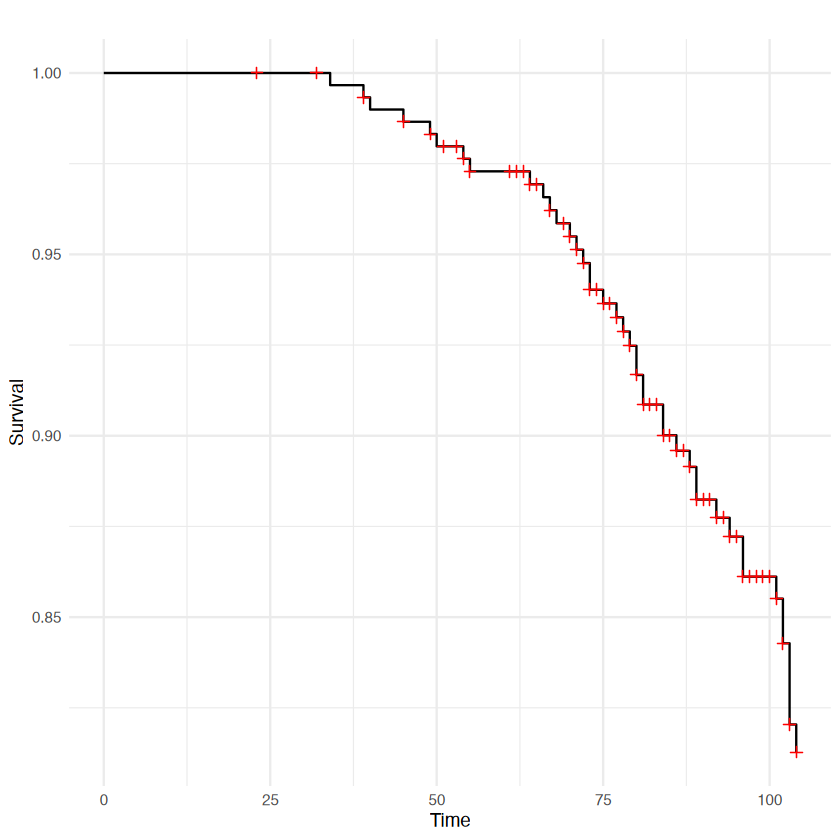

In [27]:
autoplot(tsk_rats)

In [ ]:
as.data.table(mlr_tasks)[task_type == "surv"][, 1:2]

# key     label                      
# 1  actg    ACTG 320                   
# 2  gbcs    German Breast Cancer       
# 3  gbsg    German Breast Cancer       
# 4  grace   GRACE 1000                 
# 5  lung    Lung Cancer                
# 6  mgus    MGUS                       
# 7  pbc     Primary Biliary Cholangitis
# 8  rats    Rats                       
# 9  veteran Veteran                    
# 10 whas    Worcester Heart Attack

key,label
<chr>,<chr>
actg,ACTG 320
gbcs,German Breast Cancer
gbsg,German Breast Cancer
grace,GRACE 1000
lung,Lung Cancer
mgus,MGUS
pbc,Primary Biliary Cholangitis
rats,Rats
veteran,Veteran


In [ ]:
tsk_rats <- tsk("rats")
split <- partition(tsk_rats)
prediction_cph <- lrn("surv.coxph")$
  train(tsk_rats, split$train)$
  predict(tsk_rats, split$test)
prediction_cph

# <PredictionSurv> for 99 observations:
#  row_ids time status      crank         lp     distr
#        7  104  FALSE  0.1925737  0.1925737 <list[1]>
#       10   91  FALSE -3.0832910 -3.0832910 <list[1]>
#       14  104  FALSE -0.6054056 -0.6054056 <list[1]>
#      ---  ---    ---        ---        ---       ---
#      293   75   TRUE -2.6423195 -2.6423195 <list[1]>
#      295  104  FALSE  1.4853920  1.4853920 <list[1]>
#      300  102  FALSE -2.6153858 -2.6153858 <list[1]>

<PredictionSurv> for 99 observations:
 row_ids time status      crank         lp     distr
       7  104  FALSE  0.1925737  0.1925737 <list[1]>
      10   91  FALSE -3.0832910 -3.0832910 <list[1]>
      14  104  FALSE -0.6054056 -0.6054056 <list[1]>
     ---  ---    ---        ---        ---       ---
     293   75   TRUE -2.6423195 -2.6423195 <list[1]>
     295  104  FALSE  1.4853920  1.4853920 <list[1]>
     300  102  FALSE -2.6153858 -2.6153858 <list[1]>

### predict_type = “response”

In [ ]:
library(mlr3extralearners)
prediction_svm <- lrn("surv.svm", type = "regression", gamma = 1e-3)$
  train(tsk_rats, split$train)$
  predict(tsk_rats, split$test)
data.frame(
  pred = prediction_svm$response[1:3],
  truth = prediction_svm$truth[1:3]
)

# pred     truth 
# 1 86.90290 104, 0
# 2 86.68662  91, 0
# 3 86.46788 104, 0

pred,truth
<dbl>,<Surv>
86.90290,"104, 0"
86.68662,"91, 0"
86.46788,"104, 0"


### predict_type = "dist"

In [ ]:
prediction_cph$distr[1:3]$survival(77)

# [,1]      [,2]      [,3]     
# 77 0.9054622 0.9962547 0.9562719

77,0.9054622,0.9962547,0.9562719


### predict_type = “crank”

In [ ]:
prediction_cph$crank[1:3]

# 1          2          3 
#  0.1925737 -3.0832910 -0.6054056

1          2          3 
 0.1925737 -3.0832910 -0.6054056

## 生存度量

In [ ]:
as.data.table(mlr_measures)[
  task_type == "surv",
  c("key", "predict_type")
][1:5]

# key                predict_type
# 1 surv.brier         distr       
# 2 surv.calib_alpha   distr       
# 3 surv.calib_beta    lp          
# 4 surv.calib_index   distr       
# 5 surv.chambless_auc lp

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustFPC has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustFPC.

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustFPC has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustFPC.

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustSil has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustSil.

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustFPC has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustFPC.



key,predict_type
<chr>,<chr>
surv.brier,distr
surv.calib_alpha,distr
surv.calib_beta,lp
surv.calib_index,distr
surv.chambless_auc,lp


In [ ]:
prediction_cph$score(msrs(c("surv.graf", "surv.cindex", "surv.dcalib")))

# surv.graf surv.cindex surv.dcalib 
#  0.06086923  0.76969695  1.94093328

surv.graf surv.cindex surv.dcalib 
 0.06086923  0.76969695  1.94093328

## 组合

In [ ]:
library(mlr3verse)
library(mlr3extralearners)

tsk_rats <- tsk("rats")$select(c("litter", "rx"))
split <- partition(tsk_rats)

learner <- lrn("surv.xgboost.aft", nrounds = 10)
# 没有 distr 输出
learner$train(tsk_rats, split$train)$predict(tsk_rats, split$test)

# <PredictionSurv> for 99 observations:
#  row_ids time status     crank        lp response
#        1  101  FALSE -4.613992 -4.613992 100.8861
#       11  104  FALSE -5.589596 -5.589596 267.6276
#       17   62  FALSE -5.589596 -5.589596 267.6276
#      ---  ---    ---       ---       ---      ---
#      294   64  FALSE -5.163324 -5.163324 174.7443
#      298   92  FALSE -5.266873 -5.266873 193.8089
#      300  102  FALSE -5.163324 -5.163324 174.7443

<PredictionSurv> for 99 observations:
 row_ids time status     crank        lp response
       1  101  FALSE -4.613992 -4.613992 100.8861
      11  104  FALSE -5.589596 -5.589596 267.6276
      17   62  FALSE -5.589596 -5.589596 267.6276
     ---  ---    ---       ---       ---      ---
     294   64  FALSE -5.163324 -5.163324 174.7443
     298   92  FALSE -5.266873 -5.266873 193.8089
     300  102  FALSE -5.163324 -5.163324 174.7443

In [ ]:
graph_learner <- ppl(
  "distrcompositor",
  learner = learner,
  estimator = "kaplan",
  form = "aft",
  graph_learner = TRUE
)

# now with distr
graph_learner$train(tsk_rats, split$train)$predict(tsk_rats, split$test)

# <PredictionSurv> for 99 observations:
#  row_ids time status     crank        lp response     distr
#        1  101  FALSE -4.613992 -4.613992 100.8861 <list[1]>
#       11  104  FALSE -5.589596 -5.589596 267.6276 <list[1]>
#       17   62  FALSE -5.589596 -5.589596 267.6276 <list[1]>
#      ---  ---    ---       ---       ---      ---       ---
#      294   64  FALSE -5.163324 -5.163324 174.7443 <list[1]>
#      298   92  FALSE -5.266873 -5.266873 193.8089 <list[1]>
#      300  102  FALSE -5.163324 -5.163324 174.7443 <list[1]>

<PredictionSurv> for 99 observations:
 row_ids time status     crank        lp response     distr
       1  101  FALSE -4.613992 -4.613992 100.8861 <list[1]>
      11  104  FALSE -5.589596 -5.589596 267.6276 <list[1]>
      17   62  FALSE -5.589596 -5.589596 267.6276 <list[1]>
     ---  ---    ---       ---       ---      ---       ---
     294   64  FALSE -5.163324 -5.163324 174.7443 <list[1]>
     298   92  FALSE -5.266873 -5.266873 193.8089 <list[1]>
     300  102  FALSE -5.163324 -5.163324 174.7443 <list[1]>

In [ ]:
set.seed(42)
library(mlr3extralearners)

tsk_grace <- tsk("grace")
tsk_grace$filter(sample(tsk_grace$nrow, 500))

msr_txt <- c("surv.graf", "surv.cindex", "surv.dcalib")
measures <- msrs(msr_txt)

graph_learner <- ppl(
  "distrcompositor",
  learner = lrn("surv.xgboost.aft", nrounds = 10),
  estimator = "kaplan",
  form = "aft",
  graph_learner = TRUE,
  scale_lp = TRUE
)
graph_learner$id <- "XGBoost-AFT"

learners <- c(
  lrns(c("surv.coxph", "surv.kaplan")),
  graph_learner
)

bmr <- benchmark(
  benchmark_grid(
    tsk_grace,
    learners,
    rsmp("cv", folds = 3)
  )
)

bmr$aggregate(measures)[, c("learner_id", ..msr_txt)]

# learner_id  surv.graf surv.cindex surv.dcalib
# 1 surv.coxph  0.1004525 0.8302703   6.092780   
# 2 surv.kaplan 0.2028983 0.5000000   3.088798   
# 3 XGBoost-AFT 0.2148202 0.8464122   6.459952

INFO  [10:52:51.861] [mlr3] Running benchmark with 9 resampling iterations
INFO  [10:52:51.873] [mlr3] Applying learner 'surv.coxph' on task 'grace' (iter 1/3)
INFO  [10:52:51.894] [mlr3] Applying learner 'surv.coxph' on task 'grace' (iter 2/3)
INFO  [10:52:51.933] [mlr3] Applying learner 'surv.coxph' on task 'grace' (iter 3/3)
INFO  [10:52:51.951] [mlr3] Applying learner 'surv.kaplan' on task 'grace' (iter 1/3)
INFO  [10:52:51.963] [mlr3] Applying learner 'surv.kaplan' on task 'grace' (iter 2/3)
INFO  [10:52:51.978] [mlr3] Applying learner 'surv.kaplan' on task 'grace' (iter 3/3)
INFO  [10:52:51.987] [mlr3] Applying learner 'XGBoost-AFT' on task 'grace' (iter 1/3)
INFO  [10:52:52.104] [mlr3] Applying learner 'XGBoost-AFT' on task 'grace' (iter 2/3)
INFO  [10:52:52.206] [mlr3] Applying learner 'XGBoost-AFT' on task 'grace' (iter 3/3)
INFO  [10:52:52.246] [mlr3] Finished benchmark


learner_id,surv.graf,surv.cindex,surv.dcalib
<chr>,<dbl>,<dbl>,<dbl>
surv.coxph,0.1004525,0.8302703,6.092780
surv.kaplan,0.2028983,0.5000000,3.088798
XGBoost-AFT,0.2148202,0.8464122,6.459952


# 密度估计

## 密度任务

In [ ]:
tsk_dens <- as_task_dens(data.table(x = rnorm(1000)))
tsk_dens

# <TaskDens:data.table(x = rnorm(1000))> (1000 x 1)
# * Target: -
# * Properties: -
# * Features (1):
#   - dbl (1): x

<TaskDens:data.table(x = rnorm(1000))> (1000 x 1)
* Target: -
* Properties: -
* Features (1):
  - dbl (1): x

In [ ]:
as.data.table(mlr_tasks)[task_type == "dens", c(1:2, 4:5)]

# key      label                  nrow ncol
# 1 faithful Old Faithful Eruptions 272  1   
# 2 precip   Annual Precipitation    70  1

key,label,nrow,ncol
<chr>,<chr>,<int>,<int>
faithful,Old Faithful Eruptions,272,1
precip,Annual Precipitation,70,1


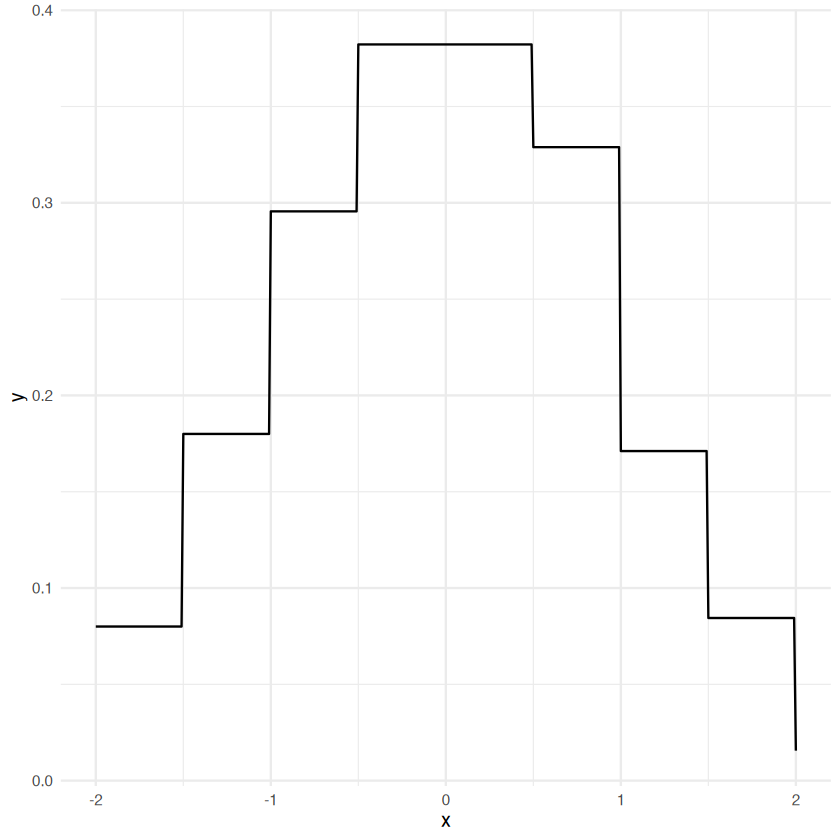

In [43]:
lrn_hist <- lrn("dens.hist")
prediction <- lrn_hist$train(tsk_dens, 1:900)$predict(tsk_dens, 901:1000)
x <- seq(-2, 2, 0.01)
df <- data.frame(x = x, y = prediction$distr$pdf(x))
ggplot(df, aes(x = x, y = y)) +
  geom_line() +
  theme_minimal()

In [ ]:
prediction = lrn_hist$train(tsk_dens, 1:10)$predict(tsk_dens, 11:13)
# pdf and cdf columns in output
prediction

# <PredictionDens> for 3 observations:
#  row_ids pdf       cdf
#       11 0.6 0.4849437
#       12 0.2 0.3992106
#       13 0.6 0.6207625

<PredictionDens> for 3 observations:
 row_ids pdf       cdf
      11 0.6 0.4849437
      12 0.2 0.3992106
      13 0.6 0.6207625
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
# comparing cdf from prediction to $cdf method from distr
cbind(
  prediction$distr$cdf(tsk_dens$data()$x[11:13]),
  prediction$cdf[1:3]
)

# [,1]      [,2]     
# [1,] 0.4849437 0.4849437
# [2,] 0.3992106 0.3992106
# [3,] 0.6207625 0.6207625

0.4849437,0.4849437
0.3992106,0.3992106
0.6207625,0.6207625


## 密度度量

In [ ]:
msr_logloss <- msr("dens.logloss")
msr_logloss

# <MeasureDensLogloss:dens.logloss>: Log Loss
# * Packages: mlr3, mlr3proba
# * Range: [0, Inf]
# * Minimize: TRUE
# * Average: macro
# * Parameters: eps=1e-15
# * Properties: -
# * Predict type: pdf

<MeasureDensLogloss:dens.logloss>: Log Loss
* Packages: mlr3, mlr3proba
* Range: [0, Inf]
* Minimize: TRUE
* Average: macro
* Parameters: eps=1e-15
* Properties: -
* Predict type: pdf

In [ ]:
prediction$score(msr_logloss)

# dens.logloss 
#    0.8770297

dens.logloss 
   0.8770297

In [ ]:
library(mlr3extralearners)

tsk_faithful <- tsk("faithful")
learners <- lrns(c("dens.hist", "dens.pen", "dens.kde"))
measure <- msr("dens.logloss")
bmr <- benchmark(
  benchmark_grid(
    tasks = tsk_faithful,
    learners = learners,
    resamplings = rsmp("cv", folds = 3)
  )
)
bmr$aggregate(measure)

# nr resample_result            task_id  learner_id resampling_id iters
# 1 1  <environment: 0x17b44a728> faithful dens.hist  cv            3    
# 2 2  <environment: 0x17b466418> faithful dens.pen   cv            3    
# 3 3  <environment: 0x17b48a220> faithful dens.kde   cv            3    
#   dens.logloss
# 1 1.097003    
# 2 1.371767    
# 3 1.019000

INFO  [11:57:50.736] [mlr3] Running benchmark with 9 resampling iterations
INFO  [11:57:50.752] [mlr3] Applying learner 'dens.hist' on task 'faithful' (iter 1/3)
INFO  [11:57:50.766] [mlr3] Applying learner 'dens.hist' on task 'faithful' (iter 2/3)
INFO  [11:57:50.776] [mlr3] Applying learner 'dens.hist' on task 'faithful' (iter 3/3)
INFO  [11:57:50.786] [mlr3] Applying learner 'dens.pen' on task 'faithful' (iter 1/3)
[1] 1
[1] 2
[1] 3
INFO  [11:57:51.776] [mlr3] Applying learner 'dens.pen' on task 'faithful' (iter 2/3)
[1] 1
[1] 2
[1] 3
INFO  [11:57:51.810] [mlr3] Applying learner 'dens.pen' on task 'faithful' (iter 3/3)
[1] 1
[1] 2
[1] 3
INFO  [11:57:51.850] [mlr3] Applying learner 'dens.kde' on task 'faithful' (iter 1/3)
INFO  [11:57:51.879] [mlr3] Applying learner 'dens.kde' on task 'faithful' (iter 2/3)
INFO  [11:57:51.919] [mlr3] Applying learner 'dens.kde' on task 'faithful' (iter 3/3)
INFO  [11:57:51.949] [mlr3] Finished benchmark


nr,resample_result,task_id,learner_id,resampling_id,iters,dens.logloss
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x17b44a728>,faithful,dens.hist,cv,3,1.097003
2,<environment: 0x17b466418>,faithful,dens.pen,cv,3,1.371767
3,<environment: 0x17b48a220>,faithful,dens.kde,cv,3,1.019000


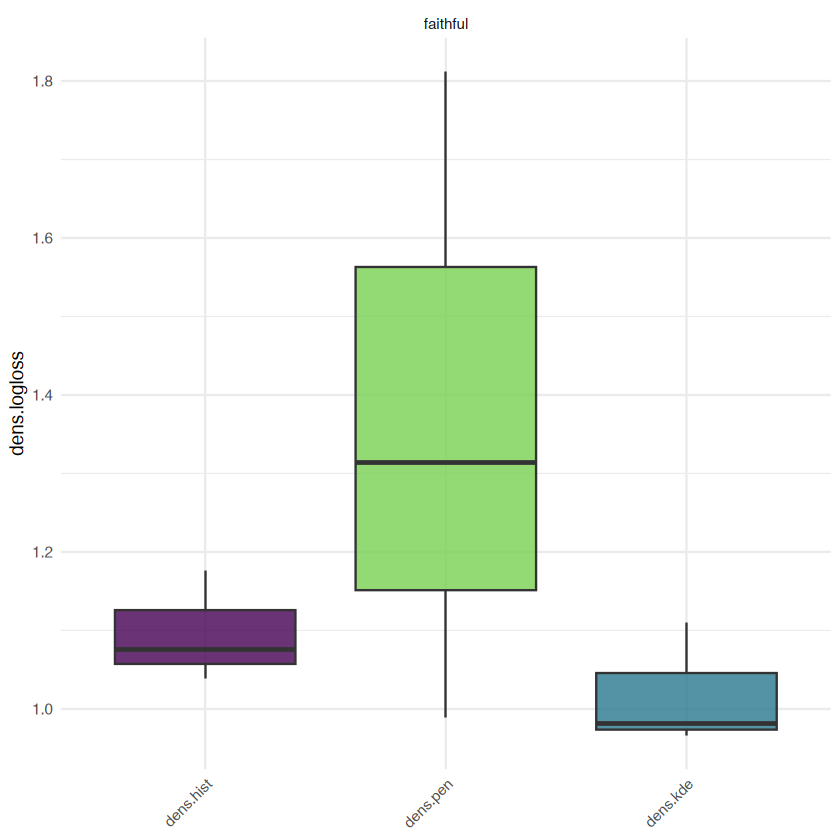

In [50]:
autoplot(bmr, measure = measure)

# 聚类分析

## 聚类任务

In [ ]:
library(mlr3verse)
library(cluster)

tsk_ruspini <- as_task_clust(ruspini)
tsk_ruspini

# <TaskClust:ruspini> (75 x 2)
# * Target: -
# * Properties: -
# * Features (2):
#   - int (2): x, y

<TaskClust:ruspini> (75 x 2)
* Target: -
* Properties: -
* Features (2):
  - int (2): x, y

In [ ]:
tsk_ruspini$data(1:3)

# x  y 
# 1  4 53
# 2  5 63
# 3 10 59

x,y
<int>,<int>
4,53
5,63
10,59


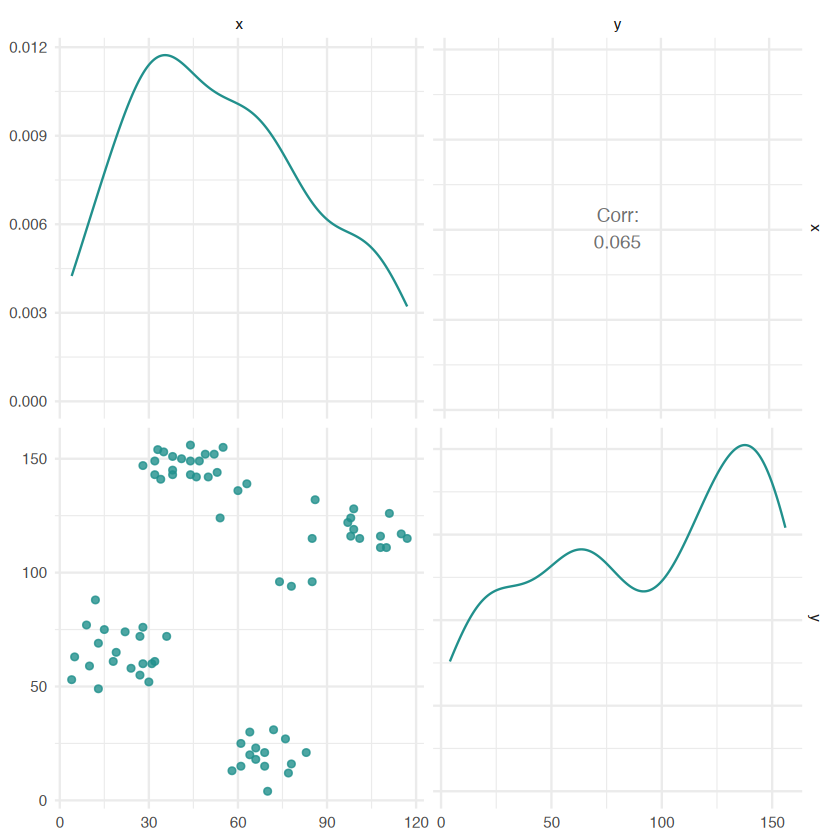

In [55]:
autoplot(tsk_ruspini)

In [ ]:
as.data.table(mlr_tasks)[task_type == "clust", c(1:2, 4:5)]

# key       label      nrow ncol
# 1 ruspini   Ruspini    75   2   
# 2 usarrests US Arrests 50   4

key,label,nrow,ncol
<chr>,<chr>,<int>,<int>
ruspini,Ruspini,75,2
usarrests,US Arrests,50,4


## 聚类学习器与聚类预测

In [ ]:
lrn_cmeans <- lrn("clust.cmeans", predict_type = "prob", centers = 3)
lrn_cmeans

# <LearnerClustCMeans:clust.cmeans>: Fuzzy C-Means Clustering Learner
# * Model: -
# * Parameters: centers=3
# * Packages: mlr3, mlr3cluster, e1071
# * Predict Types:  partition, [prob]
# * Feature Types: logical, integer, numeric
# * Properties: complete, fuzzy, partitional

<LearnerClustCMeans:clust.cmeans>: Fuzzy C-Means Clustering Learner
* Model: -
* Parameters: centers=3
* Packages: mlr3, mlr3cluster, e1071
* Predict Types:  partition, [prob]
* Feature Types: logical, integer, numeric
* Properties: complete, fuzzy, partitional

In [ ]:
lrn_cmeans$train(tsk_ruspini)
lrn_cmeans$assignments[sample(tsk_ruspini$nrow, 6)]

# [1] 2 3 2 3 3 1

[1] 2 3 2 3 3 1

In [ ]:
# using different data for estimation (rare use case)
lrn_cmeans$train(tsk_ruspini, 1:30)$predict(tsk_ruspini, 31:32)

# <PredictionClust> for 2 observations:
#  row_ids partition      prob.1    prob.2    prob.3
#       31         2 0.008319994 0.7170454 0.2746346
#       32         2 0.006463172 0.6218974 0.3716394

<PredictionClust> for 2 observations:
 row_ids partition      prob.1    prob.2    prob.3
      31         2 0.008319994 0.7170454 0.2746346
      32         2 0.006463172 0.6218974 0.3716394

Warning message in GGally::ggscatmat(data, color = "partition"):
"Factor variables are omitted in plot"


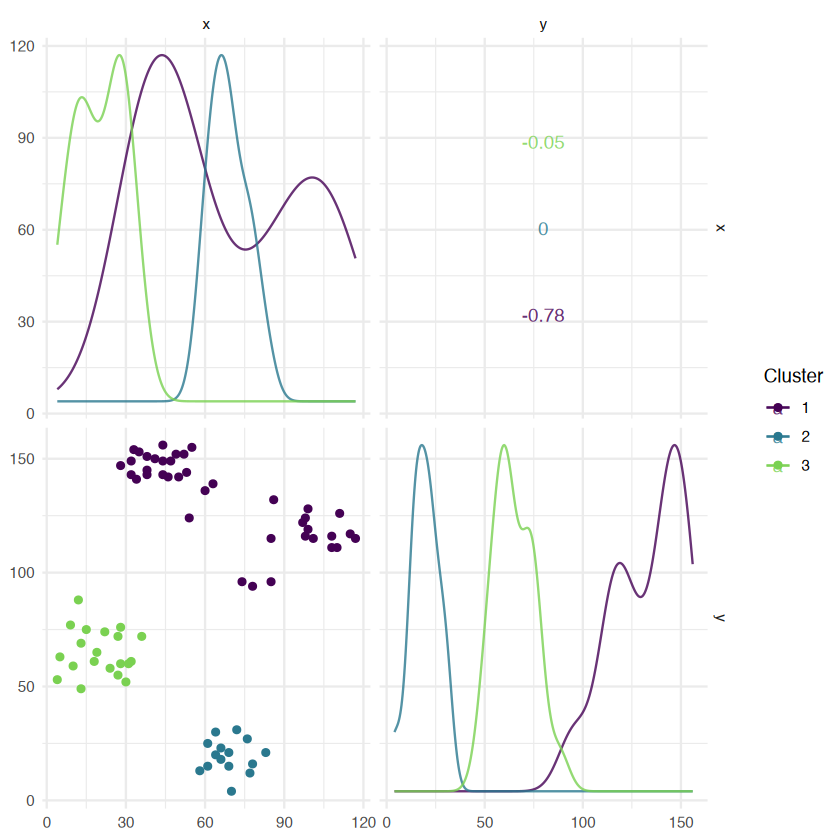

In [62]:
prediction <- lrn_cmeans$train(tsk_ruspini)$predict(tsk_ruspini)
autoplot(prediction, tsk_ruspini)

In [ ]:
lrn_hclust <- lrn("clust.hclust", k = 2)
lrn_hclust$train(tsk_ruspini)$predict(tsk_ruspini)

# Warning message in warn_prediction_useless(self$id):
# "Learner 'clust.hclust' doesn't predict on new data and predictions may not make sense on new data."

# <PredictionClust> for 75 observations:
#  row_ids partition
#        1         1
#        2         1
#        3         1
#      ---       ---
#       73         1
#       74         1
#       75         1

Warning message in warn_prediction_useless(self$id):
"Learner 'clust.hclust' doesn't predict on new data and predictions may not make sense on new data."


<PredictionClust> for 75 observations:
 row_ids partition
       1         1
       2         1
       3         1
     ---       ---
      73         1
      74         1
      75         1

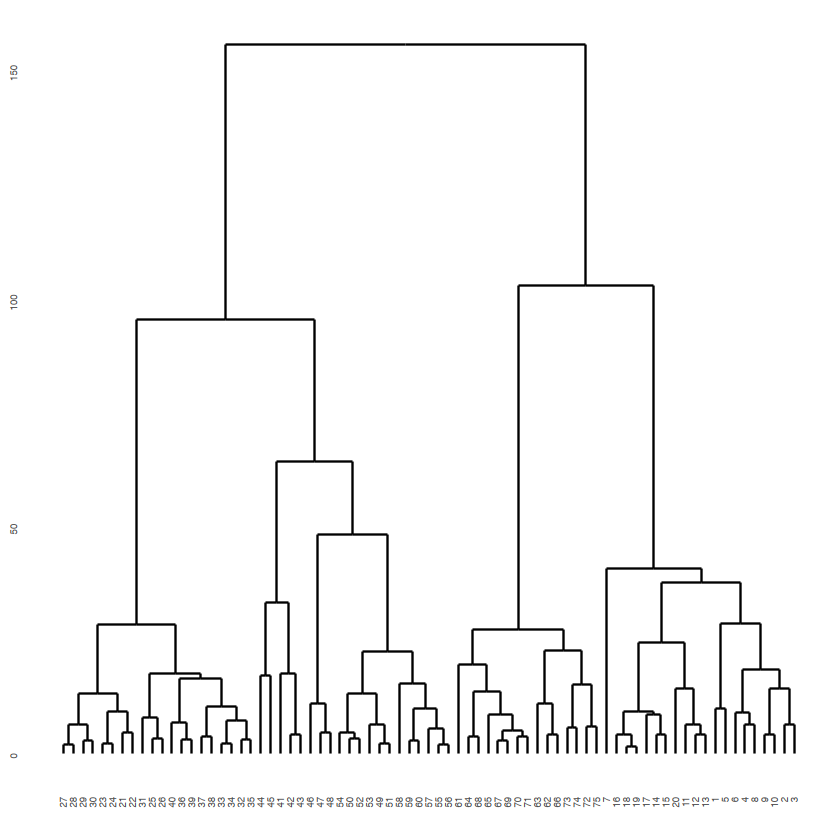

In [65]:
autoplot(lrn_hclust) + theme(axis.text = element_text(size = 5.5))

## 聚类度量

In [ ]:
msrs <- mlr_measures$keys()
msrs[grep("^clust", msrs)]

# [1] "clust.ch"         "clust.dunn"       "clust.silhouette" "clust.wss"

[1] "clust.ch"         "clust.dunn"       "clust.silhouette" "clust.wss"

In [ ]:
measures <- msrs(c("clust.wss", "clust.silhouette"))
prediction$score(measures, task = tsk_ruspini)

# clust.wss clust.silhouette 
#     5.115541e+04     6.413923e-01

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustFPC has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustFPC.

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustSil has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustSil.



clust.wss clust.silhouette 
    5.115541e+04     6.413923e-01

## 可视化

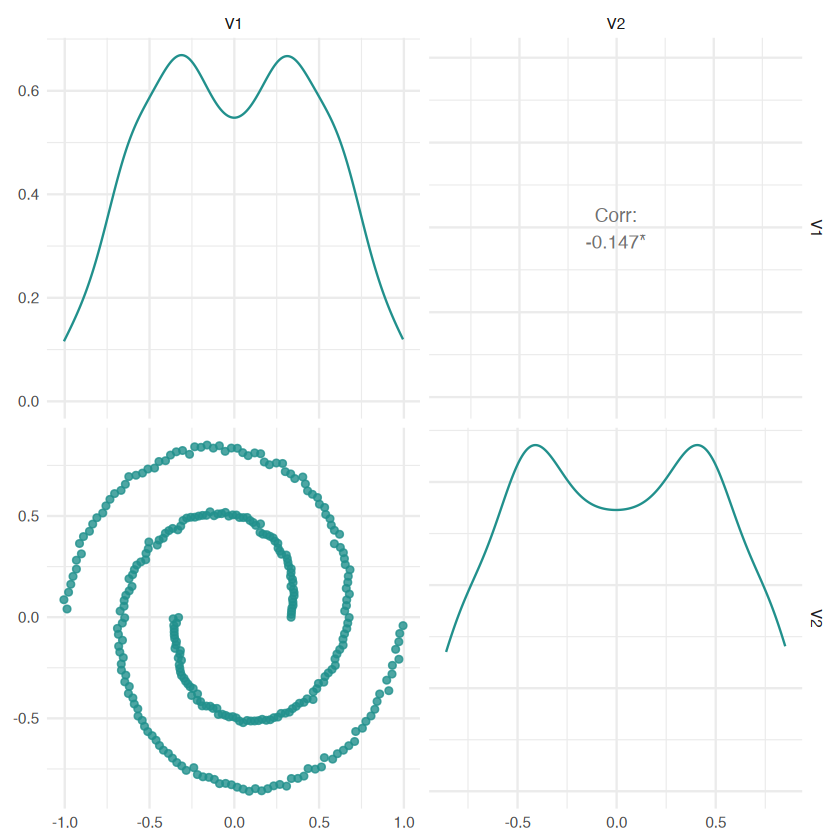

In [80]:
spirals <- mlbench::mlbench.spirals(n = 300, sd = 0.01)
tsk_spirals <- as_task_clust(as.data.frame(spirals$x))
autoplot(tsk_spirals)

In [ ]:
learners <- list(
  lrn("clust.kmeans"),
  lrn("clust.dbscan", eps = 0.1)
)

bmr <- benchmark(benchmark_grid(tsk_spirals, learners, rsmp("insample")))
bmr$aggregate(msr("clust.silhouette"))[, c("learner_id", "clust.silhouette")]

# learner_id   clust.silhouette
# 1 clust.kmeans 0.37266304      
# 2 clust.dbscan 0.02904394

INFO  [12:30:18.566] [mlr3] Running benchmark with 2 resampling iterations
INFO  [12:30:18.574] [mlr3] Applying learner 'clust.kmeans' on task 'as.data.frame(spirals$x)' (iter 1/1)
INFO  [12:30:18.589] [mlr3] Applying learner 'clust.dbscan' on task 'as.data.frame(spirals$x)' (iter 1/1)
INFO  [12:30:18.670] [mlr3] Finished benchmark


Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustSil has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustSil.



learner_id,clust.silhouette
<chr>,<dbl>
clust.kmeans,0.37266304
clust.dbscan,0.02904394


In [88]:
bmr$resample_result(1)$prediction()

<PredictionClust> for 300 observations:
 row_ids partition
       1         1
       2         1
       3         1
     ---       ---
     298         1
     299         1
     300         1

Warning message in GGally::ggscatmat(data, color = "partition"):
"Factor variables are omitted in plot"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


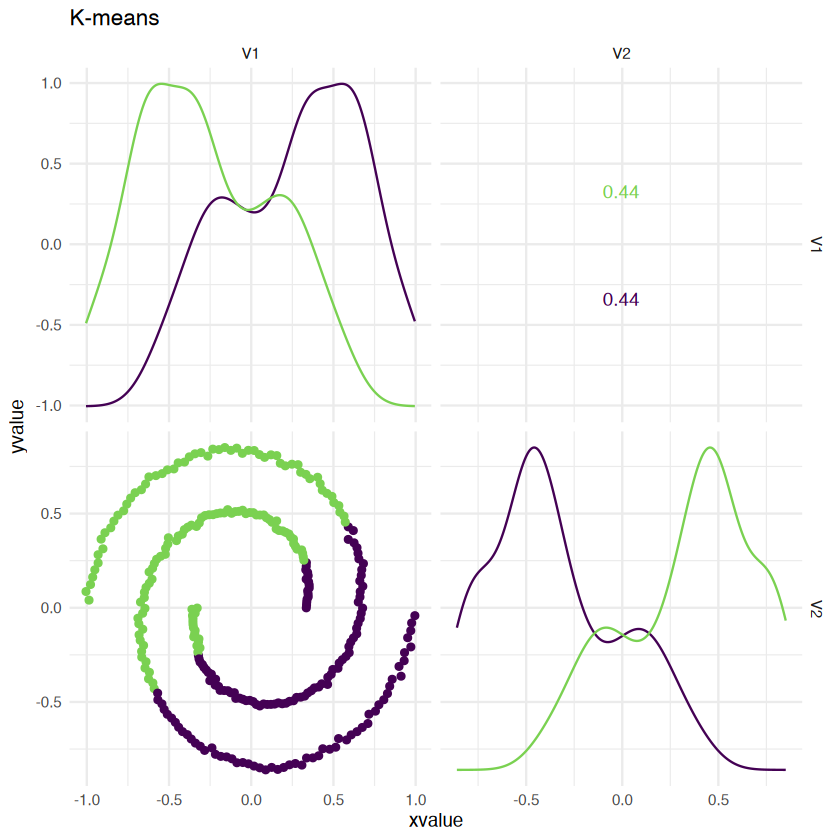

In [89]:
autoplot(bmr$resample_result(1)$prediction(), tsk_spirals) +
  ggplot2::scale_colour_viridis_d(end = 0.8) +
  ggtitle("K-means") +
  theme_minimal() +
  theme(legend.position = "none")

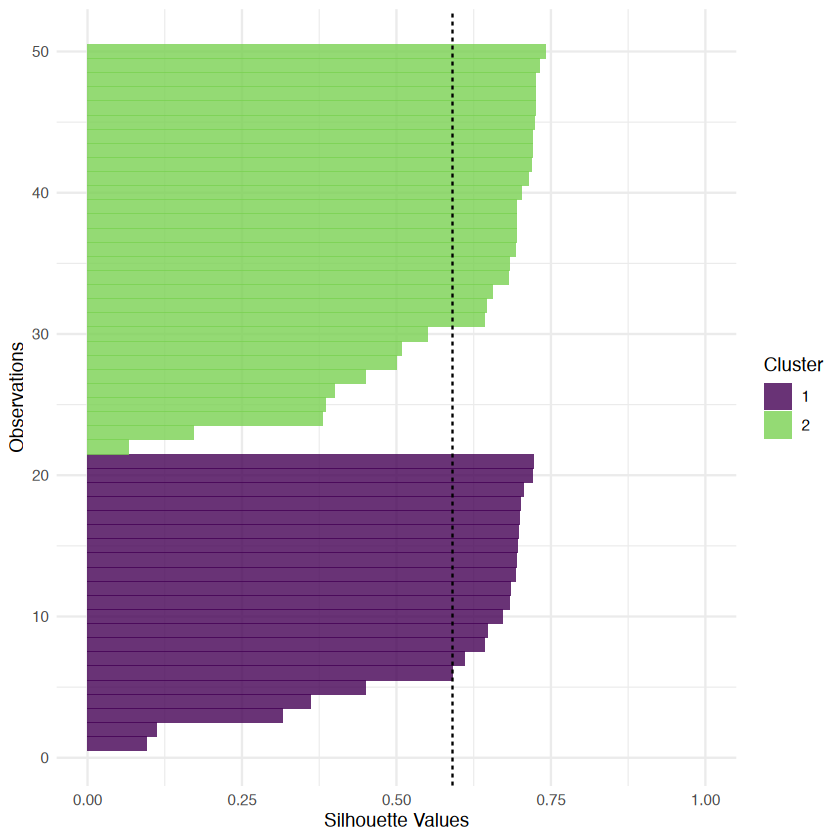

In [90]:
autoplot(prediction, tsk_usarrests, type = "sil")

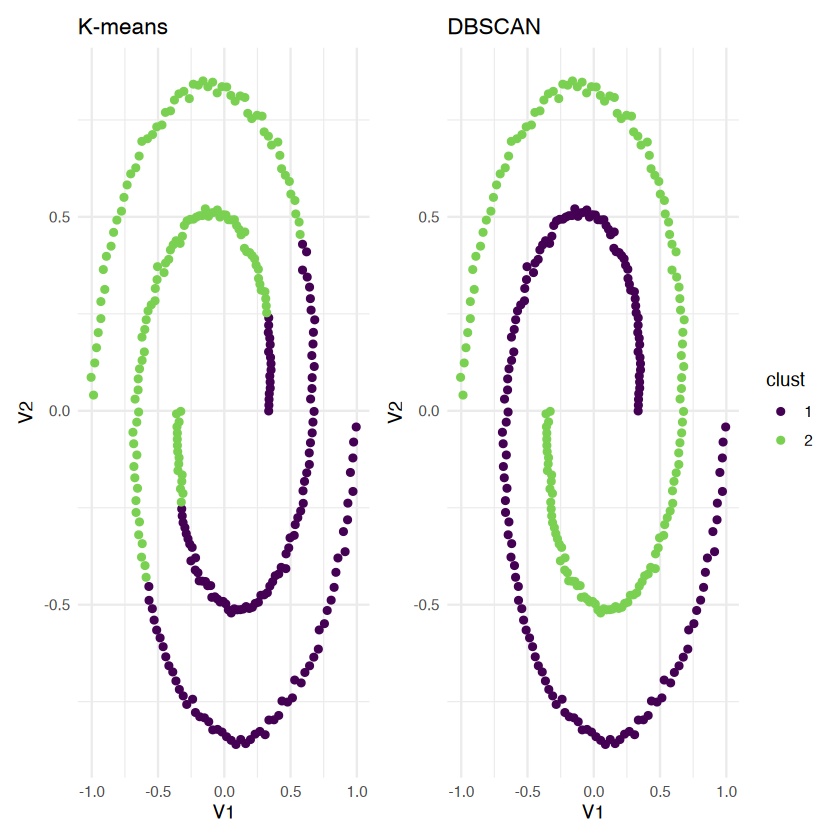

In [ ]:
library(patchwork)
# 获取 K-Means 和 DBSCAN 的聚类分区
pred_kmeans <- as.factor(bmr$resample_result(1)$prediction()$partition)
pred_dbscan <- as.factor(bmr$resample_result(2)$prediction()$partition)

# 构建数据框
df_kmeans <- cbind(tsk_spirals$data(), clust = pred_kmeans)
df_dbscan <- cbind(tsk_spirals$data(), clust = pred_dbscan)

# 绘图
map <- aes(x = V1, y = V2, color = clust)
p_kmeans <- ggplot(df_kmeans, map) + geom_point() + ggtitle("K-means") +
  theme_minimal() + ggplot2::scale_colour_viridis_d(end = 0.8)
p_dbscan <- ggplot(df_dbscan, map) + geom_point() + ggtitle("DBSCAN") +
  theme_minimal() + ggplot2::scale_colour_viridis_d(end = 0.8)

p_kmeans + p_dbscan + plot_layout(guides = "collect")

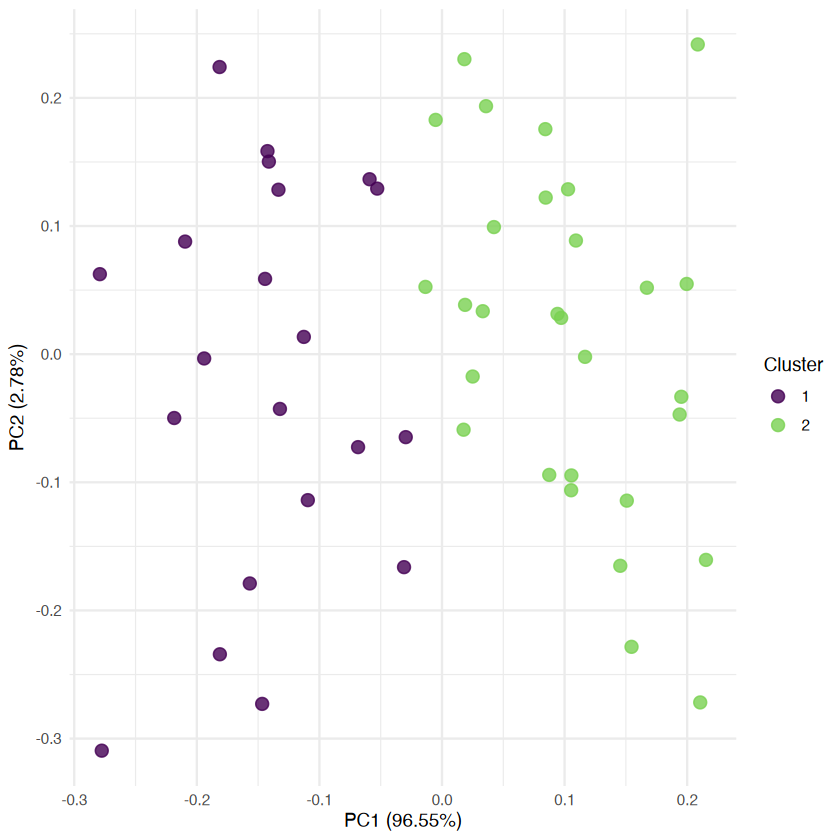

In [87]:
tsk_usarrests <- tsk("usarrests")
prediction <- lrn("clust.kmeans")$
  train(tsk_usarrests)$
  predict(tsk_usarrests)
autoplot(prediction, tsk_usarrests, type = "pca")

## 综合应用

In [ ]:
tsk_usarrests <- tsk("usarrests")
learners <- list(
  lrn("clust.featureless"),
  lrn("clust.kmeans", centers = 4L),
  lrn("clust.cmeans", centers = 3L)
)
measures <- list(msr("clust.wss"), msr("clust.silhouette"))
bmr <- benchmark(benchmark_grid(tsk_usarrests, learners, rsmp("insample")))
bmr$aggregate(measures)[, c(4, 7, 8)]

# learner_id        clust.wss clust.silhouette
# 1 clust.featureless 355807.82 0.0000000       
# 2 clust.kmeans       34728.63 0.5012332       
# 3 clust.cmeans       47964.27 0.5319024

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustFPC has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustFPC.

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustSil has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustSil.



INFO  [12:40:49.632] [mlr3] Running benchmark with 3 resampling iterations
INFO  [12:40:49.642] [mlr3] Applying learner 'clust.featureless' on task 'usarrests' (iter 1/1)
INFO  [12:40:49.654] [mlr3] Applying learner 'clust.kmeans' on task 'usarrests' (iter 1/1)
INFO  [12:40:49.666] [mlr3] Applying learner 'clust.cmeans' on task 'usarrests' (iter 1/1)
INFO  [12:40:49.677] [mlr3] Finished benchmark


learner_id,clust.wss,clust.silhouette
<chr>,<dbl>,<dbl>
clust.featureless,355807.82,0.0000000
clust.kmeans,34728.63,0.5012332
clust.cmeans,47964.27,0.5319024


# 空间分析

## 分类时空任务与回归时空任务

In [ ]:
library(mlr3spatial)
library(mlr3spatiotempcv)

# 从 data.frame 创建空间分类任务
tsk_ecuador <- as_task_classif_st(
  ecuador,
  id = "ecuador_task",
  target = "slides",
  positive = "TRUE",
  coordinate_names = c("x", "y"),
  crs = "32717"
)

# 或从 sf 对象创建任务
data_sf <- sf::st_as_sf(ecuador, coords = c("x", "y"), crs = "32717")
tsk_ecuador <- as_task_classif_st(
  data_sf,
  target = "slides",
  positive = "TRUE"
)
tsk_ecuador

# <TaskClassifST:data_sf> (751 x 11)
# * Target: slides
# * Properties: twoclass
# * Features (10):
#   - dbl (10): carea, cslope, dem, distdeforest, distroad,
#     distslidespast, hcurv, log.carea, slope, vcurv
# * Coordinates:
#             X       Y
#         <num>   <num>
#   1: 712882.5 9560002
#   2: 715232.5 9559582
#   3: 715392.5 9560172
#   4: 715042.5 9559312
#   5: 715382.5 9560142
#  ---                 
# 747: 714472.5 9558482
# 748: 713142.5 9560992
# 749: 713322.5 9560562
# 750: 715392.5 9557932
# 751: 713802.5 9560862


Attaching package: 'mlr3spatiotempcv'


The following objects are masked from 'package:mlr3spatial':

    TaskClassifST, TaskRegrST, as_task_classif_st,
    as_task_classif_st.DataBackend, as_task_classif_st.TaskClassifST,
    as_task_classif_st.data.frame, as_task_classif_st.sf,
    as_task_regr_st, as_task_regr_st.DataBackend,
    as_task_regr_st.TaskClassifST, as_task_regr_st.TaskRegrST,
    as_task_regr_st.data.frame, as_task_regr_st.sf




<TaskClassifST:data_sf> (751 x 11)
* Target: slides
* Properties: twoclass
* Features (10):
  - dbl (10): carea, cslope, dem, distdeforest, distroad,
    distslidespast, hcurv, log.carea, slope, vcurv
* Coordinates:
            X       Y
        <num>   <num>
  1: 712882.5 9560002
  2: 715232.5 9559582
  3: 715392.5 9560172
  4: 715042.5 9559312
  5: 715382.5 9560142
 ---                 
747: 714472.5 9558482
748: 713142.5 9560992
749: 713322.5 9560562
750: 715392.5 9557932
751: 713802.5 9560862

In [ ]:
lrn("classif.rpart")$train(tsk_ecuador)$predict(tsk_ecuador)

# <PredictionClassif> for 751 observations:
#  row_ids truth response
#        1  TRUE     TRUE
#        2  TRUE     TRUE
#        3  TRUE     TRUE
#      ---   ---      ---
#      749 FALSE    FALSE
#      750 FALSE    FALSE
#      751 FALSE     TRUE

<PredictionClassif> for 751 observations:
 row_ids truth response
       1  TRUE     TRUE
       2  TRUE     TRUE
       3  TRUE     TRUE
     ---   ---      ---
     749 FALSE    FALSE
     750 FALSE    FALSE
     751 FALSE     TRUE

## 时空交叉验证

In [ ]:
lrn_rpart <- lrn("classif.rpart", predict_type = "prob")
rsmp_nsp <- rsmp("repeated_cv", folds = 3, repeats = 2, id = "NSpCV")
rsmp_sp <- rsmp("repeated_spcv_coords", folds = 3, repeats = 2, id = "SpCV")

design <- benchmark_grid(tsk_ecuador, lrn_rpart, c(rsmp_nsp, rsmp_sp))
bmr <- benchmark(design)
bmr$aggregate(msr("classif.acc"))[, c(5, 7)]

# resampling_id classif.acc
# 1 NSpCV         0.6737689  
# 2 SpCV          0.5842370

INFO  [12:50:57.564] [mlr3] Running benchmark with 12 resampling iterations
INFO  [12:50:57.580] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 1/6)
INFO  [12:50:57.607] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 2/6)
INFO  [12:50:57.624] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 3/6)
INFO  [12:50:57.648] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 4/6)
INFO  [12:50:57.663] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 5/6)
INFO  [12:50:57.679] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 6/6)
INFO  [12:50:57.697] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 1/6)
INFO  [12:50:57.711] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 2/6)
INFO  [12:50:57.733] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 3/6)
INFO  [12:50:57.748] [mlr3] Applying learner 'classif.rpart' on task 'data_sf' (iter 4/6)
INFO  [12:50:57.886] [ml

resampling_id,classif.acc
<chr>,<dbl>
NSpCV,0.6737689
SpCV,0.5842370


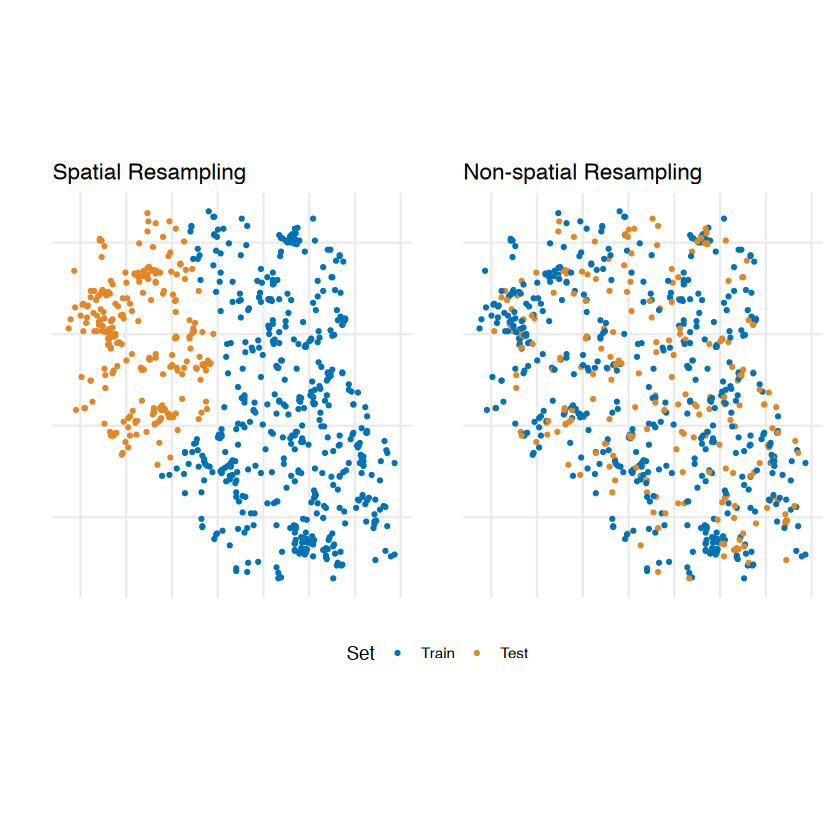

In [97]:
library(patchwork)

p1 <- autoplot(rsmp_sp, tsk_ecuador, fold_id = 1, size = 0.7) +
  ggtitle("Spatial Resampling")
p2 <- autoplot(rsmp_nsp, tsk_ecuador, fold_id = 1, size = 0.7) +
  ggtitle("Non-spatial Resampling")

(p1 + p2) +
  plot_layout(guides = "collect") &
  theme_minimal() &
  theme(axis.text = element_text(size = 4), legend.position = "bottom")

## 空间预测

In [101]:
library(mlr3spatial)
library(sf)
library(terra, exclude = "resample")

# load sample points
leipzig_vector <- sf::read_sf(
  system.file("extdata", "leipzig_points.gpkg", package = "mlr3spatial"),
  stringsAsFactors = TRUE
)
# create training data
tsk_leipzig <- as_task_classif_st(leipzig_vector, target = "land_cover")

# load raster image
leipzig_raster <- terra::rast(
  system.file("extdata", "leipzig_raster.tif", package = "mlr3spatial")
)

In [102]:
lrn_ranger <- lrn("classif.ranger")$train(tsk_leipzig)
prediction <- predict_spatial(
  leipzig_raster,
  lrn_ranger,
  format = "terra"
)

Warning message in warn_deprecated("DataBackend$data_formats"):
"DataBackend$data_formats is deprecated and will be removed in the future."


INFO  [12:56:05.457] [mlr3] Start raster prediction
INFO  [12:56:05.465] [mlr3] Prediction is executed with a chunksize of 200 Megabytes, 1 chunk(s) in total, 31724 values per chunk
INFO  [12:56:06.268] [mlr3] Chunk 1 of 1 finished
INFO  [12:56:06.271] [mlr3] Finished raster prediction in 0 seconds


In [ ]:
prediction

# class       : SpatRaster 
# dimensions  : 206, 154, 1  (nrow, ncol, nlyr)
# resolution  : 10, 10  (x, y)
# extent      : 731810, 733350, 5692030, 5694090  (xmin, xmax, ymin, ymax)
# coord. ref. : WGS 84 / UTM zone 32N (EPSG:32632) 
# source      : fileb379782f8a33.tif 
# categories  : categories 
# name        : land_cover 
# min value   :     forest 
# max value   :      water

class       : SpatRaster 
dimensions  : 206, 154, 1  (nrow, ncol, nlyr)
resolution  : 10, 10  (x, y)
extent      : 731810, 733350, 5692030, 5694090  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / UTM zone 32N (EPSG:32632) 
source      : fileb379782f8a33.tif 
categories  : categories 
name        : land_cover 
min value   :     forest 
max value   :      water 

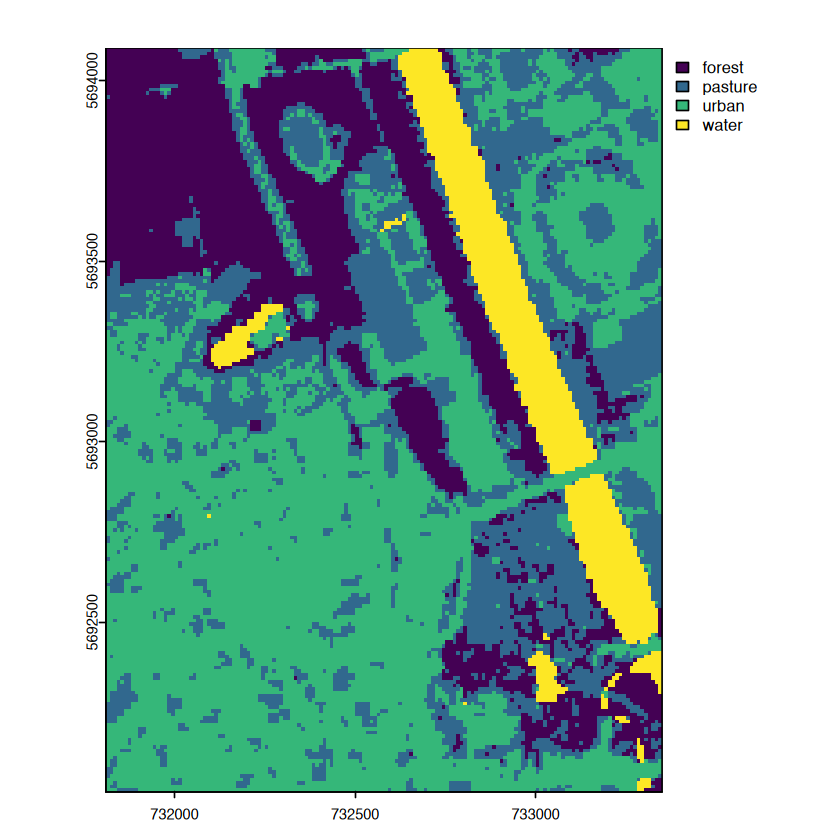

In [104]:
plot(
  prediction,
  col = c(
    "#440154FF", "#443A83FF", "#31688EFF",
    "#21908CFF", "#35B779FF", "#8FD744FF", "#FDE725FF"
  )
)

# 练习

## 练习1

In [ ]:
# 定义任务
tsk_german <- tsk("german_credit")

# 定义代价矩阵
costs <- matrix(
  c(-10, 2, 3, -1),
  nrow = 2,
  dimnames = list(
    "Predicted Credit" = c("good", "bad"),
    Truth = c("good", "bad")
  )
)
print(costs)

# 定义度量指标
msr_costs <- msr("classif.costs", costs = costs)

# 定义学习器
glrn_featureless <- as_learner(
  po("learner_cv", lrn("classif.featureless", predict_type = "prob")) %>>%
    po("tunethreshold", measure = msr_costs)
)
glrn_featureless$id <- "featureless_tune_threshold"
glrn_log_reg <- as_learner(
  po("learner_cv", lrn("classif.log_reg", predict_type = "prob")) %>>%
    po("tunethreshold", measure = msr_costs)
)
glrn_log_reg$id <- "log_reg_tune_threshold"
glrn_ranger <- as_learner(
  po("learner_cv", lrn("classif.ranger", predict_type = "prob")) %>>%
    po("tunethreshold", measure = msr_costs)
)
glrn_ranger$id <- "ranger_tune_threshold"

# 定义基准测试
bmr <- benchmark(
  benchmark_grid(
    tasks = tsk_german,
    learners = list(glrn_featureless, glrn_log_reg, glrn_ranger),
    resamplings = rsmp("cv", folds = 3)
  )
)

# 聚合结果
bmr$aggregate(msr_costs)[, c(4, 7)]

# learner_id                 classif.costs
# 1 featureless_tune_threshold -6.100304    
# 2 log_reg_tune_threshold     -6.120336    
# 3 ranger_tune_threshold      -6.068404

                Truth
Predicted Credit good bad
            good  -10   3
            bad     2  -1
INFO  [13:07:22.832] [mlr3] Running benchmark with 9 resampling iterations
INFO  [13:07:22.839] [mlr3] Applying learner 'featureless_tune_threshold' on task 'german_credit' (iter 1/3)
INFO  [13:07:22.895] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 1/3)
INFO  [13:07:22.905] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 2/3)
INFO  [13:07:22.914] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 3/3)
INFO  [13:07:23.400] [mlr3] Applying learner 'featureless_tune_threshold' on task 'german_credit' (iter 2/3)
INFO  [13:07:23.416] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 1/3)
INFO  [13:07:23.422] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 2/3)
INFO  [13:07:23.427] [mlr3] Applying learner 'classif.featureless' on task 'german_credit' (iter 

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.

OptimInstanceSingleCrit is deprecated. Use OptimInstanceBatchSingleCrit instead.



INFO  [13:07:29.605] [mlr3] Finished benchmark


learner_id,classif.costs
<chr>,<dbl>
featureless_tune_threshold,-6.100304
log_reg_tune_threshold,-6.120336
ranger_tune_threshold,-6.068404


## 练习2

In [ ]:
# 加载必要包
library(mlr3verse)
library(mlr3extralearners)

# 加载生存分析任务
tsk_rats <- tsk("rats")

# 数据集划分（80% 训练，20% 测试）
split <- partition(tsk_rats, ratio = 0.8)
train_ids <- split$train
test_ids <- split$test

# 定义生存森林模型
learner <- lrn("surv.rfsrc")

# 在训练集上训练模型
learner$train(tsk_rats, row_ids = train_ids)

# 在测试集上预测
prediction <- learner$predict(tsk_rats, row_ids = test_ids)

# 用 RCLL 指标评估模型
rcll_score <- prediction$score(msr("surv.rcll"))
print(rcll_score)

# surv.rcll 
#  3.220126

surv.rcll 
 3.220126 


## 练习3

In [ ]:
library(mlr3verse)
library(mlr3proba)
library(mlr3extralearners)

# 加载密度估计任务
tsk_precip <- tsk("precip")

# 定义直方图密度估计学习器
lrn_hist <- lrn("dens.hist")

# 训练模型
lrn_hist$train(tsk_precip)

# 预测（在同一数据上）
prediction <- lrn_hist$predict(tsk_precip)

# 用 logloss 评估密度估计
logloss <- prediction$score(msr("dens.logloss"))
print(logloss)

# dens.logloss 
#     3.896488 

dens.logloss 
    3.896488 


## 练习4

In [119]:
wine <- tsk("wine")$data()
wine %>% glimpse()

Rows: 178
Columns: 14
$ type            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ alcalinity      <dbl> 15.6, 11.2, 18.6, 16.8, 21.0, 15.2, 14.6, 17.6, 14.0, ~
$ alcohol         <dbl> 14.23, 13.20, 13.16, 14.37, 13.24, 14.20, 14.39, 14.06~
$ ash             <dbl> 2.43, 2.14, 2.67, 2.50, 2.87, 2.45, 2.45, 2.61, 2.17, ~
$ color           <dbl> 5.64, 4.38, 5.68, 7.80, 4.32, 6.75, 5.25, 5.05, 5.20, ~
$ dilution        <dbl> 3.92, 3.40, 3.17, 3.45, 2.93, 2.85, 3.58, 3.58, 2.85, ~
$ flavanoids      <dbl> 3.06, 2.76, 3.24, 3.49, 2.69, 3.39, 2.52, 2.51, 2.98, ~
$ hue             <dbl> 1.04, 1.05, 1.03, 0.86, 1.04, 1.05, 1.02, 1.06, 1.08, ~
$ magnesium       <int> 127, 100, 101, 113, 118, 112, 96, 121, 97, 98, 105, 95~
$ malic           <dbl> 1.71, 1.78, 2.36, 1.95, 2.59, 1.76, 1.87, 2.15, 1.64, ~
$ nonflavanoids   <dbl> 0.28, 0.26, 0.30, 0.24, 0.39, 0.34, 0.30, 0.31, 0.29, ~
$ phenols         <dbl> 2.80, 2.65, 2.80, 3.85, 2.80, 3.27, 2.50, 2.60, 2.80, ~
$ proanthocyanins 

In [ ]:
# 创建任务
tsk_wine <- as_task_clust(wine[, -1], id = "wine_task")

# 定义学习器k=2,3,4
learners <- list(
  lrn("clust.kmeans", centers = 2, id = "kmeans_2"),
  lrn("clust.kmeans", centers = 3, id = "kmeans_3"),
  lrn("clust.kmeans", centers = 4, id = "kmeans_4")
)

# 定义度量指标
msr_silhouette <- msr("clust.silhouette")

# 定义基准测试
bmr <- benchmark(
  benchmark_grid(
    tasks = tsk_wine,
    learners = learners,
    resamplings = rsmp("cv", folds = 3)
  )
)

# 聚合结果
bmr$aggregate(msr_silhouette)[, c(4, 7)]

# learner_id clust.silhouette
# 1 kmeans_2   0.6414256       
# 2 kmeans_3   0.5587260       
# 3 kmeans_4   0.5209588

Superclass MeasureClust has cloneable=FALSE, but subclass MeasureClustSil has cloneable=TRUE. A subclass cannot be cloneable when its superclass is not cloneable, so cloning will be disabled for MeasureClustSil.



INFO  [13:28:03.339] [mlr3] Running benchmark with 9 resampling iterations
INFO  [13:28:03.347] [mlr3] Applying learner 'kmeans_2' on task 'wine_task' (iter 1/3)
INFO  [13:28:03.361] [mlr3] Applying learner 'kmeans_2' on task 'wine_task' (iter 2/3)
INFO  [13:28:03.373] [mlr3] Applying learner 'kmeans_2' on task 'wine_task' (iter 3/3)
INFO  [13:28:03.383] [mlr3] Applying learner 'kmeans_3' on task 'wine_task' (iter 1/3)
INFO  [13:28:03.405] [mlr3] Applying learner 'kmeans_3' on task 'wine_task' (iter 2/3)
INFO  [13:28:03.418] [mlr3] Applying learner 'kmeans_3' on task 'wine_task' (iter 3/3)
INFO  [13:28:03.432] [mlr3] Applying learner 'kmeans_4' on task 'wine_task' (iter 1/3)
INFO  [13:28:03.452] [mlr3] Applying learner 'kmeans_4' on task 'wine_task' (iter 2/3)
INFO  [13:28:03.465] [mlr3] Applying learner 'kmeans_4' on task 'wine_task' (iter 3/3)
INFO  [13:28:03.481] [mlr3] Finished benchmark


learner_id,clust.silhouette
<chr>,<dbl>
kmeans_2,0.6414256
kmeans_3,0.5587260
kmeans_4,0.5209588
